## Recommendation System Using Content and Collaborative Filtering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Connecting Neo4j desktop to python

In [2]:
from neo4j import GraphDatabase

url= 'bolt://localhost:7687'
user = 'neo4j'
password = 'password'

driver = GraphDatabase.driver(url, auth=(user, password))
# fetch_data function returns the DataFrame based on cypher query and paramaeters passing
def fetch_data(query, params={}):
  with driver.session(database = 'neo4j') as session:
    result = session.run(query, params)
    return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [3]:
fetch_data('''CREATE OR REPLACE DATABASE neo4j''')

""


Creating Nodes in the database: 

Movies -> {title,movieId}

Users -> {userId}

Genres -> {name}

Person -> {name}

In [4]:
fetch_data('''
LOAD CSV WITH HEADERS FROM
'file:///movies.csv' AS row
CREATE (:Movie {title: row.title, movieId: toInteger(row.movieId)})
''')

""


In [5]:
fetch_data('''
LOAD CSV WITH HEADERS FROM
'file:///users.csv' AS row
CREATE (:User {userId: toInteger(row.userId)})
''')

""


In [6]:
fetch_data('''
LOAD CSV WITH HEADERS FROM
'file:///genres.csv' AS row
CREATE (:Genre {name: row.genre})
''')

""


In [7]:
fetch_data('''
LOAD CSV WITH HEADERS FROM
'file:///actors.csv' AS row
CREATE (:Person {name: row.actor})
''')

""


In [8]:
fetch_data('''
LOAD CSV WITH HEADERS FROM
'file:///directors.csv' AS row
MERGE (:Person {name: row.director})
''')

""


In [9]:
fetch_data('''CREATE CONSTRAINT ON (user:User) ASSERT user.userId IS UNIQUE''')

""


In [10]:
fetch_data('''CREATE CONSTRAINT ON (movie:Movie) ASSERT movie.movieId IS UNIQUE''')

""


Establishing relations between nodes:

RATED

IN_GENRE

ACTED_IN

DIRECTED

In [11]:
fetch_data('''
LOAD CSV WITH HEADERS FROM
'file:///train_set.csv' AS row
MATCH (user:User {userId: toInteger(row.userId)})
MATCH (movie:Movie {movieId: toInteger(row.movieId)})
MERGE (user)-[:RATED {rating: toFloat(row.rating)}]->(movie)
''')

""


In [12]:
fetch_data('''CREATE CONSTRAINT ON (genre:Genre) ASSERT genre.name IS UNIQUE''')

""


In [13]:
fetch_data('''
LOAD CSV WITH HEADERS FROM
'file:///movies_genres.csv' AS row
MATCH (movie:Movie {movieId: toInteger(row.movieId)})
MATCH (genre:Genre {name: row.genre})
MERGE (movie)-[:IN_GENRE]->(genre)
''')

""


In [14]:
fetch_data('''CREATE CONSTRAINT ON (person:Person) ASSERT person.name IS UNIQUE''')

""


In [15]:
fetch_data('''
LOAD CSV WITH HEADERS FROM
'file:///movies_actors.csv' AS row
MATCH (movie:Movie {movieId: toInteger(row.movieId)})
MATCH (person:Person {name: row.actor})
MERGE (movie)<-[:ACTED_IN]-(person)
''')

""


In [16]:
fetch_data('''
LOAD CSV WITH HEADERS FROM
'file:///movies_directors.csv' AS row
MATCH (movie:Movie {movieId: toInteger(row.movieId)})
MATCH (person:Person {name: row.director})
MERGE (movie)<-[:DIRECTED]-(person)
''')

""


### Content based recommendation using Jaccard Similarity

we build  Content Based Recommenders based on:
* Movie Cast, Crew  and Genre

In [17]:
fetch_data('''MATCH (m:Movie {title: "Star Wars"})-[:IN_GENRE|ACTED_IN|DIRECTED]-(t)-[:IN_GENRE|ACTED_IN|DIRECTED]-(other:Movie)
WITH m, other, COLLECT(t.name) AS i
MATCH (m)-[:IN_GENRE|ACTED_IN|DIRECTED]-(mt)
WITH m,other,i, COLLECT(DISTINCT id(mt)) AS s1
MATCH (other)-[:IN_GENRE|ACTED_IN|DIRECTED]-(ot)
WITH m,other,i, s1, COLLECT(DISTINCT id(ot)) AS s2

WITH m,other,s1,s2

RETURN m.title AS movie, other.title AS recommendation, gds.similarity.jaccard(s1,s2) AS jaccard ORDER BY jaccard DESC LIMIT 25''')


,movie,recommendation,jaccard
0,Star Wars,The Empire Strikes Back,0.111111
1,Star Wars,Empire of Dreams: The Story of the Star Wars T...,0.075758
2,Star Wars,Return of the Jedi,0.070796
3,Star Wars,Star Wars: Episode III - Revenge of the Sith,0.048485
4,Star Wars,Star Wars: The Force Awakens,0.047368
5,Star Wars,Raiders of the Lost Ark,0.044872
6,Star Wars,Rollerball,0.040650
7,Star Wars,Star Wars: Episode II - Attack of the Clones,0.040000
8,Star Wars,Superman II,0.037975
9,Star Wars,Star Wars: Episode I - The Phantom Menace,0.036145


In [21]:
fetch_data('''
MATCH(u:User {userId: $user})-[:RATED]->(m:Movie)-[:IN_GENRE|ACTED_IN|DIRECTED]-(t)-[:IN_GENRE|ACTED_IN|DIRECTED]-(other:Movie)
WHERE NOT EXISTS ((u)-[:RATED]->(other))
WITH m, other, COLLECT(t.name) AS i
MATCH (m)-[:IN_GENRE|ACTED_IN|DIRECTED]-(mt)
WITH m,other,i, COLLECT(DISTINCT id(mt)) AS s1
MATCH (other)-[:IN_GENRE|ACTED_IN|DIRECTED]-(ot)
WITH m,other,i, s1, COLLECT(DISTINCT id(ot)) AS s2

WITH m,other,s1,s2

RETURN m.title AS movie, other.title AS recommendation, gds.similarity.jaccard(s1,s2) AS jaccard ORDER BY jaccard DESC LIMIT 25''',{'user':14})


,movie,recommendation,jaccard
0,Toy Story 2,Toy Story,0.466667
1,Stuart Little,Stuart Little 2,0.312500
2,Toy Story 2,Toy Story 3,0.293103
3,Austin Powers: The Spy Who Shagged Me,Austin Powers: International Man of Mystery,0.261905
4,Toy Story 2,Toy Story of Terror!,0.218750
5,Runaway Bride,Pretty Woman,0.205882
6,Star Wars: Episode I - The Phantom Menace,Star Wars: Episode II - Attack of the Clones,0.186813
7,The Cat from Outer Space,The Apple Dumpling Gang,0.181818
8,Runaway Bride,Raising Helen,0.177778
9,For Love of the Game,Boys,0.176471


In [25]:
train_set = pd.read_csv('train_set.csv')
train_set

,userId,movieId,rating
0,1,1339,3.5
1,1,1263,2.0
2,1,1405,1.0
3,1,1129,2.0
4,1,2968,1.0
...,...,...,...
79517,671,5989,4.0
79518,671,589,5.0
79519,671,4973,4.5
79520,671,2355,4.0


In [22]:
liked_test_set = pd.read_csv('liked_test_set.csv')
liked_test_set

,userId,movieId,rating
0,1,1029,3.0
1,2,50,4.0
2,2,551,5.0
3,2,153,4.0
4,2,10,4.0
...,...,...,...
11391,671,5952,5.0
11392,671,2396,4.0
11393,671,4995,4.0
11394,671,6365,4.0


In [23]:
content_df = pd.DataFrame(columns=['userId','movieId','score'])

In [27]:
for u in range(1,11):
    cont_df = train_set[train_set['userId']==u]
    cont_df = cont_df.sort_values(by=['rating'], ascending=False)
    top_movies = cont_df['movieId'][:5].values
    cont = pd.DataFrame(columns=['userId','movieId','score'])
    query = '''MATCH (m:Movie {movieId: $i})-[:IN_GENRE|ACTED_IN|DIRECTED]-(t)-[:IN_GENRE|ACTED_IN|DIRECTED]-(other:Movie)
    WITH m, other, COUNT(t) AS intersection, COLLECT(t.name) AS i
    MATCH (m)-[:IN_GENRE|ACTED_IN|DIRECTED]-(mt)
    WITH m,other, intersection,i, COLLECT(mt.name) AS s1
    MATCH (other)-[:IN_GENRE|ACTED_IN|DIRECTED]-(ot)
    WITH m,other,intersection,i, s1, COLLECT(ot.name) AS s2

    WITH m,other,intersection,s1,s2

    WITH m,other,intersection,s1+[x IN s2 WHERE NOT x IN s1] AS union, s1, s2

    RETURN other.movieId AS movieId,((1.0*intersection)/SIZE(union)) AS score ORDER BY score DESC LIMIT 5'''
    
    for i in top_movies:
        result = fetch_data(query,{'i':int(i)})
        cont = pd.concat([cont,result],ignore_index=True)
    cont = cont.sort_values(by=['score'], ascending=False,ignore_index=True)[:20]
    cont['userId']=u
    content_df = pd.concat([content_df,cont],ignore_index=True)
    
content_df  

,userId,movieId,score
0,1,87975,0.142857
1,1,7812,0.137931
2,1,8811,0.136364
3,1,3699,0.133333
4,1,6219,0.133333
...,...,...,...
195,10,207,0.125000
196,10,6027,0.125000
197,10,2598,0.120000
198,10,499,0.115385


In [28]:
test = liked_test_set[liked_test_set['userId'].isin([1,2,3,4,5,6,7,8,9,10])]
result_df = pd.merge(test,content_df,on=['userId','movieId'],how='inner')
result_df

,userId,movieId,rating,score
0,2,153,4.0,0.102564
1,4,296,5.0,0.149254
2,6,5952,5.0,0.479167


In [29]:
test_df = test.groupby(['userId'])['userId'].count().reset_index(name='test_count')
test_df

,userId,test_count
0,1,1
1,2,7
2,3,7
3,4,29
4,5,13
5,6,3
6,7,7
7,8,14
8,9,7
9,10,5


In [30]:
rec_df = content_df.groupby(['userId'])['userId'].count().reset_index(name='rec_count')
rec_df

,userId,rec_count
0,1,20
1,2,20
2,3,20
3,4,20
4,5,20
5,6,20
6,7,20
7,8,20
8,9,20
9,10,20


In [31]:
match_df = result_df.groupby(['userId'])['userId'].count().reset_index(name='match_count')
match_df

,userId,match_count
0,2,1
1,4,1
2,6,1


**Precision and Recall**

Precision and Recall at cutoff k, P@k, and r@k, are simply the precision and recall calculated by considering only the subset of your recommendations from rank 1 through k. The rank of the recommendations is determined by the predicted value. For eg., the product with the highest predicted value is ranked 1, the product with the kth highest predicted value is ranked k.
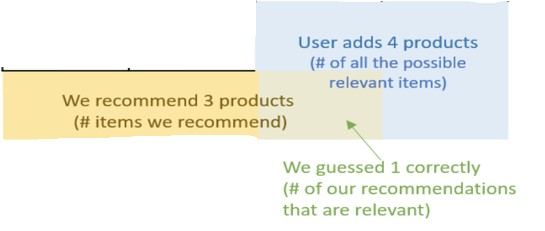

In [32]:
precision_df = pd.merge(rec_df,match_df, on = 'userId',how='left')
precision_df['match_count'] = precision_df['match_count'].fillna(0)
precision_df['precision'] = precision_df['match_count']/precision_df['rec_count']
precision_df['precision'].mean()

0.015000000000000003

Recall Calculation

In [33]:
recall_df = pd.merge(test_df,match_df, on = 'userId',how='left')
recall_df['match_count'] = recall_df['match_count'].fillna(0)
recall_df['recall'] = recall_df['match_count']/recall_df['test_count']
recall_df['recall'].mean()

0.051067323481116575

**Precision@20 = 0.0150**

**Recall@20 = 0.051067**

### Collaborative Filterring



#### Cosine Similarity
​
 the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:
​
$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $

Users similar to user 14 using cosine similarity

In [19]:
fetch_data('''MATCH (p1:User {userId: $user})-[x:RATED]->(m:Movie)<-[y:RATED]-(p2:User)
WITH COUNT(m) AS numbermovies, SUM(x.rating * y.rating) AS xyDotProduct,
SQRT(REDUCE(xDot = 0.0, a IN COLLECT(x.rating) | xDot + a^2)) AS xLength,
SQRT(REDUCE(yDot = 0.0, b IN COLLECT(y.rating) | yDot + b^2)) AS yLength,
p1, p2 WHERE numbermovies > 10
RETURN p1.userId, p2.userId, xyDotProduct / (xLength * yLength) AS sim
ORDER BY sim DESC
LIMIT 25''', {'user':14})


,p1.userId,p2.userId,sim
0,14,73,0.897368


Collaborative recommendation using cosine similarity

In [20]:
fetch_data('''MATCH (p1:User {userId: $user})-[x:RATED]->(m:Movie)<-[y:RATED]-(p2:User)
WITH COUNT(m) AS numbermovies, SUM(x.rating * y.rating) AS xyDotProduct,
SQRT(REDUCE(xDot = 0.0, a IN COLLECT(x.rating) | xDot + a^2)) AS xLength,
SQRT(REDUCE(yDot = 0.0, b IN COLLECT(y.rating) | yDot + b^2)) AS yLength,
p1, p2 WHERE numbermovies > 10
WITH p1, p2, xyDotProduct / (xLength * yLength) AS sim
ORDER BY sim DESC
LIMIT 25

MATCH (p2)-[r:RATED]->(m:Movie) WHERE NOT EXISTS( (p1)-[:RATED]->(m) )

RETURN m.title, m.movieId, SUM( sim * r.rating) AS score
ORDER BY score DESC LIMIT 25''', {'user':14})


,m.title,m.movieId,score
0,Megamind,81564,4.48684
1,Elite Squad: The Enemy Within,85342,4.48684
2,Guardians of the Galaxy,112852,4.48684
3,The Usual Suspects,50,4.48684
4,"The Good, the Bad and the Ugly",1201,4.48684
5,Mad Max: Fury Road,122882,4.48684
6,Alien,1214,4.48684
7,Indiana Jones and the Last Crusade,1291,4.48684
8,Return of the Jedi,1210,4.48684
9,Platoon,1090,4.48684


In [34]:
col = pd.DataFrame(columns=['userId','movieId','title','score'])

In [35]:
query = '''MATCH (p1:User{userId:$i})-[x:RATED]->(m:Movie)<-[y:RATED]-(p2:User)
    WITH COUNT(m) AS numbermovies, SUM(x.rating * y.rating) AS xyDotProduct,
    SQRT(REDUCE(xDot = 0.0, a IN COLLECT(x.rating) | xDot + a^2)) AS xLength,
    SQRT(REDUCE(yDot = 0.0, b IN COLLECT(y.rating) | yDot + b^2)) AS yLength,
    p1, p2 WHERE numbermovies > 10
    WITH p1, p2, xyDotProduct / (xLength * yLength) AS sim
    ORDER BY sim DESC
    LIMIT 10

    MATCH (p2)-[r:RATED]->(m:Movie) WHERE NOT EXISTS( (p1)-[:RATED]->(m) )

    RETURN p1.userId as userId,m.movieId AS movieId,m.title AS title, SUM( sim * r.rating) AS score
    ORDER BY score DESC LIMIT 20'''
for i in range(1,672):
    result = fetch_data(query,{'i':i})
    col = pd.concat([col,result],ignore_index=True)
col

,userId,movieId,title,score
0,1,7063,Aguirre: The Wrath of God,8.171253
1,1,778,Trainspotting,8.163224
2,1,1204,Lawrence of Arabia,8.163224
3,1,1,Toy Story,8.163224
4,1,1213,GoodFellas,8.163224
...,...,...,...,...
12935,671,5418,The Bourne Identity,18.352655
12936,671,1270,Back to the Future,17.857093
12937,671,480,Jurassic Park,17.840306
12938,671,1246,Dead Poets Society,17.832620


In [36]:
result_df = pd.merge(col,liked_test_set,on=['userId','movieId'],how='inner')
result_df

,userId,movieId,title,score,rating
0,2,589,Terminator 2: Judgment Day,21.592765,5.0
1,4,1240,The Terminator,27.878306,5.0
2,4,1580,Men in Black,21.909064,5.0
3,4,296,Pulp Fiction,18.423532,5.0
4,6,5952,The Lord of the Rings: The Two Towers,35.656749,5.0
...,...,...,...,...,...
1224,671,5952,The Lord of the Rings: The Two Towers,20.821131,5.0
1225,671,919,The Wizard of Oz,18.839395,4.0
1226,671,260,Star Wars,18.821426,5.0
1227,671,457,The Fugitive,18.813883,4.0


In [37]:
test_df = liked_test_set.groupby(['userId'])['userId'].count().reset_index(name='test_count')
test_df

,userId,test_count
0,1,1
1,2,7
2,3,7
3,4,29
4,5,13
...,...,...
664,667,5
665,668,2
666,669,4
667,670,5


In [38]:
rec_df = col.groupby(['userId'])['userId'].count().reset_index(name='rec_count')
rec_df

,userId,rec_count
0,1,20
1,2,20
2,3,20
3,4,20
4,5,20
...,...,...
642,666,20
643,667,20
644,669,20
645,670,20


In [39]:
match_df = result_df.groupby(['userId'])['userId'].count().reset_index(name='match_count')
match_df

,userId,match_count
0,2,1
1,4,3
2,6,1
3,8,2
4,9,2
...,...,...
456,664,13
457,665,4
458,666,3
459,670,1


In [40]:
precision_df = pd.merge(rec_df,match_df, on = 'userId',how='left')
precision_df['match_count'] = precision_df['match_count'].fillna(0)
precision_df['precision'] = precision_df['match_count']/precision_df['rec_count']
precision_df

,userId,rec_count,match_count,precision
0,1,20,0.0,0.00
1,2,20,1.0,0.05
2,3,20,0.0,0.00
3,4,20,3.0,0.15
4,5,20,0.0,0.00
...,...,...,...,...
642,666,20,3.0,0.15
643,667,20,0.0,0.00
644,669,20,0.0,0.00
645,670,20,1.0,0.05


In [41]:
precision_df['precision'].mean()

0.09497681607418845

In [42]:
recall_df = pd.merge(test_df,match_df, on = 'userId',how='left')
recall_df['match_count'] = recall_df['match_count'].fillna(0)
recall_df['recall'] = recall_df['match_count']/recall_df['test_count']
recall_df

,userId,test_count,match_count,recall
0,1,1,0.0,0.000000
1,2,7,1.0,0.142857
2,3,7,0.0,0.000000
3,4,29,3.0,0.103448
4,5,13,0.0,0.000000
...,...,...,...,...
664,667,5,0.0,0.000000
665,668,2,0.0,0.000000
666,669,4,0.0,0.000000
667,670,5,1.0,0.200000


In [43]:
recall_df['recall'].mean()

0.1672087412121887

***Precision@20 = 0.0949***

***Recall@20 = 0.167***

Compared to Content based Collaborative Filtering getting better results